In [37]:
# There's a weird issue that yfinance can't be downloaded if it's imported after tensorflow, moving the import to the top solves it.

import yfinance as yf
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)
print(yf.__version__)

TensorFlow Version:  2.19.0
0.2.63


In [38]:
# Fetching data for a stock
try:
  aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01', auto_adjust=True)
except yf.YFRateLimitError as e:
  print(f"Rate limit exceeded: {e}")

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800
2020-01-06,72.487862,72.526549,70.783263,71.034724,118387200
2020-01-07,72.146950,72.753831,71.926922,72.497537,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200


In [39]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.ffill(inplace=True)

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

In [41]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

In [42]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [43]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 60, 50)    │     10,400 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 60, 50)    │     20,200 │ lstm_28[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_30          │ (None, 50, 60)    │          0 │ lstm_29[0][0]     │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_28          │ (None, 50, 60)    │          0 │ permute_30[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 50, 60)    │         60 │ reshape_28[0][0], │
│ (AdditiveAttention) │                   │            │ reshape_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 50, 60)    │          0 │ reshape_28[0][0], │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_31          │ (None, 60, 50)    │          0 │ multiply_12[0][0] │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_29          │ (None, 60, 50)    │          0 │ permute_31[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 3000)      │          0 │ reshape_29[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      3,001 │ flatten_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,661 (131.49 KB)

 Trainable params: 33,661 (131.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 0.2354 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0127 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0057 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0055 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0056 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0051 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0051 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0052 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0051 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 1

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Predicted Stock Prices for the next day:  [[202.67311]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Stock Prices for the next 4 days:  [202.67311, 201.32733, 200.23796, 199.3662]
<class 'list'> (4,)


[*********************100%***********************]  1 of 1 completed


2025-06-19    202.673111
2025-06-20    201.327332
2025-06-21    200.237961
2025-06-22    199.366196
Name: Close, dtype: float64
<class 'numpy.ndarray'> (4,)
DatetimeIndex(['2025-06-19', '2025-06-20', '2025-06-21', '2025-06-22'], dtype='datetime64[ns]', freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
['2025-06-19T00:00:00.000000000' '2025-06-20T00:00:00.000000000'
 '2025-06-21T00:00:00.000000000' '2025-06-22T00:00:00.000000000']
(4,)
(4,)


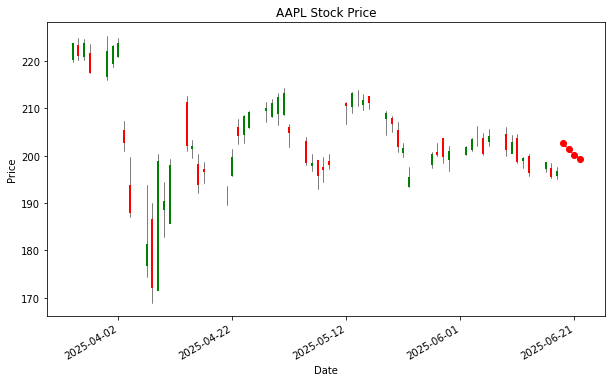

In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply, Input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf # Import yfinance

# Define input shape
input_shape = (X_train.shape[1], 1)

# Create an Input layer
inputs = Input(shape=input_shape)

# Adding LSTM layers with return_sequences=True
x = LSTM(units=50, return_sequences=True)(inputs)
x = LSTM(units=50, return_sequences=True)(x)

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
x = Permute((2, 1))(x)
x = Reshape((-1, input_shape[0]))(x)  # Use input_shape[0] instead of X_train.shape[1]
attention_result = attention([x, x])  # Use 'x' instead of 'model.output'
x = Multiply()([x, attention_result])
# Return to original shape
x = Permute((2, 1))(x)
x = Reshape((-1, 50))(x)

# Adding a Flatten layer before the final Dense layer
x = tf.keras.layers.Flatten()(x)

# Final Dense layer
outputs = Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Train the model
#history_1 = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history_2 = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

# Callback to save the model periodically (best_model.h5 for legacy)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard (visualization)
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE without using the 'squared' argument.
# Take the square root of MSE to get RMSE.
mse = mean_squared_error(y_test, y_pred) # Remove squared=False
rmse = np.sqrt(mse)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d', auto_adjust=True)

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].to_numpy()

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 days
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next day: ", predicted_stock_price)

#Next 4 days#

# Select 'Close' price and scale it
# closing_prices = data['Close'].values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_value = scaler.inverse_transform(next_prediction).flatten()[0]
    predicted_prices.append(predicted_value)

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)
print(type(predicted_prices), np.array(predicted_prices).shape)



# Fetch the latest 60 days of AAPL stock data (this should be done before plotting)
data = yf.download('AAPL', period='60d', interval='1d', auto_adjust=True)

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
prediction_dates = pd.to_datetime(np.array(prediction_dates))
predictions_df = pd.DataFrame({'Close': np.array(predicted_prices, dtype=np.float64)}, index=prediction_dates)

# Plotting the actual data with matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

# Convert index to datetime objects for plotting
data.index = pd.to_datetime(data.index)

# Create candlestick chart
for i in range(len(data)):
    # Define candlestick coordinates
    x = mdates.date2num(data.index[i])  # Convert date to numeric
    # Access data using .iloc to get values by row and column index
    open_price = data['Open'].iloc[i]
    high_price = data['High'].iloc[i]
    low_price = data['Low'].iloc[i]
    close_price = data['Close'].iloc[i]

    # Draw candlestick
    # Compare the actual values instead of the Series objects
    # Use .item() to get the scalar value from the Series
    if close_price.item() > open_price.item():
        color = 'green'
    else:
        color = 'red'
    ax.plot([x, x], [low_price, high_price], color='black', linewidth=0.5)  # Wick
    ax.plot([x, x], [open_price, close_price], color=color, linewidth=2)  # Body

# Set x-axis format to dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()  # Auto-format dates for better readability

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('AAPL Stock Price')

print(predictions_df['Close'])
print(type(predictions_df['Close'].values), predictions_df['Close'].values.shape)

print(predictions_df.index)
print(type(predictions_df.index))
print(predictions_df.index.values)
print(predictions_df.index.values.shape)
print(predictions_df['Close'].values.shape)

# Overlaying the predicted data
# ax.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')
x = mdates.date2num(predictions_df.index.to_pydatetime())
y = predictions_df['Close'].values.astype(float)
ax.plot(x, y, linestyle='dashed', marker='o', color='red')

plt.show()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 60, 50)    │     10,400 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 60, 50)    │     20,200 │ lstm_30[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_32          │ (None, 50, 60)    │          0 │ lstm_31[0][0]     │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_30          │ (None, 50, 60)    │          0 │ permute_32[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 50, 60)    │         60 │ reshape_30[0][0], │
│ (AdditiveAttention) │                   │            │ reshape_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 50, 60)    │          0 │ reshape_30[0][0], │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_33          │ (None, 60, 50)    │          0 │ multiply_13[0][0] │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_31          │ (None, 60, 50)    │          0 │ permute_33[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 3000)      │          0 │ reshape_31[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3000)      │          0 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000)      │     12,000 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      3,001 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,661 (178.36 KB)

 Trainable params: 39,661 (154.93 KB)

 Non-trainable params: 6,000 (23.44 KB)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - loss: 0.1329 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0143 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0066 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.0065 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 0.0050 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0052 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0063 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0058 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0038 - val_loss: 0.0104 - learning_rate: 1.0000e-04


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Stock Prices for the next day:  [[200.13193]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Stock Prices for the next 4 days:  [200.13193, 200.0568, 199.97789, 199.89093]
<class 'list'> (4,)


[*********************100%***********************]  1 of 1 completed


2025-06-19    200.131927
2025-06-20    200.056793
2025-06-21    199.977890
2025-06-22    199.890930
Name: Close, dtype: float64
<class 'numpy.ndarray'> (4,)
DatetimeIndex(['2025-06-19', '2025-06-20', '2025-06-21', '2025-06-22'], dtype='datetime64[ns]', freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
['2025-06-19T00:00:00.000000000' '2025-06-20T00:00:00.000000000'
 '2025-06-21T00:00:00.000000000' '2025-06-22T00:00:00.000000000']
(4,)
(4,)


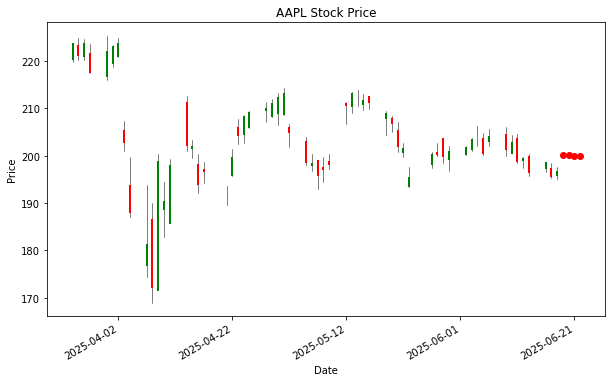

In [45]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply, Input, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf # Import yfinance
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define input shape
input_shape = (X_train.shape[1], 1)

# Create an Input layer
inputs = Input(shape=input_shape)

# Adding LSTM layers with return_sequences=True
x = LSTM(units=50, return_sequences=True)(inputs)
x = LSTM(units=50, return_sequences=True)(x)

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
x = Permute((2, 1))(x)
x = Reshape((-1, input_shape[0]))(x)  # Use input_shape[0] instead of X_train.shape[1]
attention_result = attention([x, x])  # Use 'x' instead of 'model.output'
x = Multiply()([x, attention_result])
# Return to original shape
x = Permute((2, 1))(x)
x = Reshape((-1, 50))(x)

# Adding a Flatten layer before the final Dense layer
x = tf.keras.layers.Flatten()(x)

# Adding Dropout and Batch Normalization
x = Dropout(0.2)(x) # Add dropout to the Functional API style
x = BatchNormalization()(x) # Add BatchNormalization to the Functional API style

# Final Dense layer
outputs = Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

# Adding EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

# Callback to save the model periodically (best_model.h5 for legacy)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard (visualization)
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE without using the 'squared' argument.
# Take the square root of MSE to get RMSE.
mse = mean_squared_error(y_test, y_pred) # Remove squared=False
rmse = np.sqrt(mse)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d', auto_adjust=True)

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].to_numpy()

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 days
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next day: ", predicted_stock_price)

#Next 4 days#

# Select 'Close' price and scale it
# closing_prices = data['Close'].values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_value = scaler.inverse_transform(next_prediction).flatten()[0]
    predicted_prices.append(predicted_value)

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)
print(type(predicted_prices), np.array(predicted_prices).shape)



# Fetch the latest 60 days of AAPL stock data (this should be done before plotting)
data = yf.download('AAPL', period='60d', interval='1d', auto_adjust=True)

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
prediction_dates = pd.to_datetime(np.array(prediction_dates))
predictions_df = pd.DataFrame({'Close': np.array(predicted_prices, dtype=np.float64)}, index=prediction_dates)

# Plotting the actual data with matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

# Convert index to datetime objects for plotting
data.index = pd.to_datetime(data.index)

# Create candlestick chart
for i in range(len(data)):
    # Define candlestick coordinates
    x = mdates.date2num(data.index[i])  # Convert date to numeric
    # Access data using .iloc to get values by row and column index
    open_price = data['Open'].iloc[i]
    high_price = data['High'].iloc[i]
    low_price = data['Low'].iloc[i]
    close_price = data['Close'].iloc[i]

    # Draw candlestick
    # Compare the actual values instead of the Series objects
    # Use .item() to get the scalar value from the Series
    if close_price.item() > open_price.item():
        color = 'green'
    else:
        color = 'red'
    ax.plot([x, x], [low_price, high_price], color='black', linewidth=0.5)  # Wick
    ax.plot([x, x], [open_price, close_price], color=color, linewidth=2)  # Body

# Set x-axis format to dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()  # Auto-format dates for better readability

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('AAPL Stock Price')

print(predictions_df['Close'])
print(type(predictions_df['Close'].values), predictions_df['Close'].values.shape)

print(predictions_df.index)
print(type(predictions_df.index))
print(predictions_df.index.values)
print(predictions_df.index.values.shape)
print(predictions_df['Close'].values.shape)

# Overlaying the predicted data
# ax.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')
x = mdates.date2num(predictions_df.index.to_pydatetime())
y = predictions_df['Close'].values.astype(float)
ax.plot(x, y, linestyle='dashed', marker='o', color='red')

plt.show()